# Task 3
In this task, the goal was to load and analyze data obtained through a Single Store workspace. A pipeline was created to ingest the data, connecting Singlestore's workspace to a Kafka workspace via MySQL. Subsequently, queries were executed to view the table, and the data was downloaded as a CSV file.<p>

The dataset consists of AdTech data related to events, containing information about the advertiser, viewer's gender, income, and address, as well as the campaign name. We will use this data to conduct exploratory data analysis (EDA) and go deeper into its features.

In [902]:
#Do the necessary imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pycountry
import squarify
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from sklearn.feature_selection import mutual_info_classif



In [903]:
#Reading and Merging the two tables

df_events = pd.read_csv('events.csv')
df_campaigns = pd.read_csv('campaign.csv')
df_events = df_events.merge(df_campaigns, left_on='campaign', right_on='campaign_id')
df_events = df_events.drop(columns=['campaign_id','campaign'])

In [904]:
# Display the first few rows of the dataframe
df_events.head()

,user_id,event_name,advertiser,gender,income,page_url,region,country,campaign_name
0,636647351,Impression,7-Eleven,Male,25k - 50k,/2016/04/lars-book-club-april.html/,undefined,IL,dream burger
1,636647351,Impression,7-Eleven,Male,25k - 50k,/2016/04/lars-book-club-april.html/,undefined,IL,dream burger
2,636647351,Impression,7-Eleven,Male,25k - 50k,/2016/04/lars-book-club-april.html/,undefined,IL,dream burger
3,636647351,Impression,7-Eleven,Male,25k - 50k,/2016/04/lars-book-club-april.html/,undefined,IL,dream burger
4,636647351,Impression,7-Eleven,Male,25k - 50k,/2016/04/lars-book-club-april.html/,undefined,IL,dream burger


In [905]:
# Check for missing values and data types
print(df_events.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   user_id        1000000 non-null  int64 
 1   event_name     1000000 non-null  object
 2   advertiser     1000000 non-null  object
 3   gender         1000000 non-null  object
 4   income         1000000 non-null  object
 5   page_url       999899 non-null   object
 6   region         1000000 non-null  object
 7   country        1000000 non-null  object
 8   campaign_name  1000000 non-null  object
dtypes: int64(1), object(8)
memory usage: 68.7+ MB
None


So the data present two numm values for the page_url column, and all of the columns except the user_id are categorical columns

In [906]:
# Summary statistics for categorical data
print(df_events.describe(include=['O']))

        event_name advertiser   gender   income page_url      region  country  \
count      1000000    1000000  1000000  1000000   999899     1000000  1000000   
unique           3         97        3        6     3585         100       86   
top     Impression     Subway     Male  unknown        /  California       US   
freq        874257      92346   472303   356659   112810      125754   677452   

       campaign_name  
count        1000000  
unique            13  
top     dream burger  
freq          241460  


Now we can see some stats for categorical, like, US is the country with more events and Subway the top 1 advertiser

In [907]:
# Remove duplicates
df_events = df_events.drop_duplicates()

In [908]:
df_events

,user_id,event_name,advertiser,gender,income,page_url,region,country,campaign_name
0,636647351,Impression,7-Eleven,Male,25k - 50k,/2016/04/lars-book-club-april.html/,undefined,IL,dream burger
6,636647391,Impression,Sherwin-Williams,Male,50k - 75k,/2015/04/diy-paper-plants.html/3/,Maine,US,thank you
12,636647391,Impression,Sherwin-Williams,Male,50k - 75k,/?s=daily+drawing,Maine,US,dream burger
18,636647444,Impression,The Kroger Co.,Male,unknown,/2013/04/weekend-project-fruit-welcome-mats.html/,Pennsylvania,US,designed by you
24,636647444,Impression,The Kroger Co.,Male,unknown,/2012/11/how-to-make-holiday-leaf-crown.html/,Pennsylvania,US,warmth
...,...,...,...,...,...,...,...,...,...
999974,637629812,Impression,TJX,unknown,25k and below,/2012/05/guide-to-reykjavik-vintage-shopping.h...,California,US,designed by you
999980,637629874,Impression,Foot Locker,Female,50k - 75k,/2014/07/balloon-arch-tutorial.html/7/,California,US,flame broiled
999986,637629897,Click,Royal Ahold / Ahold USA,Male,25k - 50k,/2014/05/flamingo-pop-a-bridal-shower-collab-w...,North Carolina,US,thank you
999992,637629897,Downstream Conversion,Royal Ahold / Ahold USA,Male,25k - 50k,/2014/05/flamingo-pop-a-bridal-shower-collab-w...,North Carolina,US,thank you


We can see that after removing the duplicate rows the data decreased considerably

In [909]:
df_events[df_events['user_id'] == 2147483647]

,user_id,event_name,advertiser,gender,income,page_url,region,country,campaign_name
3476,2147483647,Click,7-Eleven,Male,unknown,/2016/05/this-week-94.html/,Oregon,US,demand great
3477,2147483647,Click,7-Eleven,Male,100k+,/2014/03/5-ways-to-gift-wrap-for-spring.html/?...,Maryland,US,blackout
3478,2147483647,Click,7-Eleven,unknown,50k - 75k,/2015/08/fruit-wrapping-paper.html/,New Jersey,US,flame broiled
3479,2147483647,Click,7-Eleven,Male,100k+,/2013/04/scoring-your-dream-design-internship....,Maryland,US,flame broiled
3480,2147483647,Click,7-Eleven,unknown,25k and below,/2016/05/day-29-how-to-draw-an-eryngium.html/,Ohio,US,flame broiled
...,...,...,...,...,...,...,...,...,...
25504,2147483647,Impression,YUM! Brands,Male,100k+,/2016/05/day-20-how-to-draw-an-anemone.html/,Ohio,US,dream burger
25505,2147483647,Impression,YUM! Brands,Male,100k+,/,Ohio,US,dream burger
25506,2147483647,Impression,YUM! Brands,Male,100k+,/2014/01/print-make-origami-business-card-hold...,Ohio,US,dream burger
25507,2147483647,Impression,YUM! Brands,Male,50k - 75k,/2015/08/fruit-wrapping-paper.html/,Maharashtra,IN,dream burger


gender - fill 'unknown' in with majority, check if this make difference in the results<p>
income - fill 'unknown' with majority but keep the different values, if the majority is not clear, fill with the majority of the same gender, region and country. inputation

The same user can present an event with known and unknown values for the gender and income metrics, and also with different values for the income 

Let's process the 'unknown'values by doing imputation:

First, we are going to plot the gender and income feature to visualize the distribution of 'unknown'values

In [910]:
df_pre_imput = df_events[['gender', 'income']].copy()

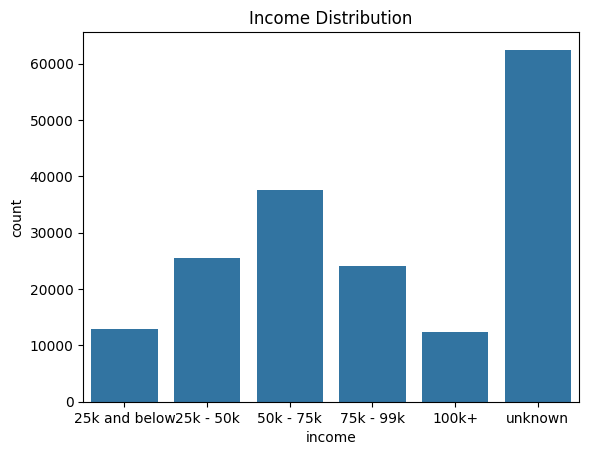

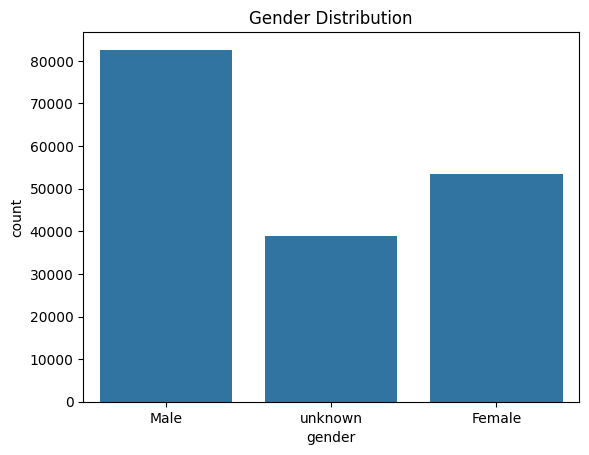

In [911]:
sns.countplot(x='income', data=df_events, order=['25k and below','25k - 50k','50k - 75k','75k - 99k','100k+', 'unknown'])
plt.title('Income Distribution')
plt.show()

# Bar chart for 'gender'
sns.countplot(x='gender', data=df_events)
plt.title('Gender Distribution')
plt.show()

In [912]:
df_imput = df_events[['gender', 'income']].copy()
df_events['income_source'] = np.where(df_imput['income'].isin(['25k and below','25k - 50k','50k - 75k','75k - 99k','100k+']), 'Original', 'Post Imputation')
df_events['gender_source'] = np.where(df_imput['gender'].isin(['Male', 'Female']), 'Original', 'Post Imputation')

In [913]:
df_events.gender_source.value_counts()

gender_source
Original           136059
Post Imputation     38833
Name: count, dtype: int64

In [914]:
df_events.gender.value_counts()

gender
Male       82618
Female     53441
unknown    38833
Name: count, dtype: int64

In [915]:
df_known_gender = df_events[df_events['gender'].isin(['Male', 'Female'])]

df_gender_distribution = df_known_gender.groupby(['advertiser', 'income',  'campaign_name', 'gender'], as_index=False).size()

total_counts = df_gender_distribution.groupby(['advertiser', 'income',  'campaign_name'])['size'].transform('sum')#Get the total Males and Females for each group
df_gender_distribution['percentage'] = 100 * df_gender_distribution['size'] / total_counts #Calculate the percentual of males and females

df_gender_distribution = df_gender_distribution.pivot_table(
    index=['advertiser', 'income', 'campaign_name'],
    columns='gender',
    values='percentage'
).fillna(0) #Getting the pivot table for all the information

df_gender_distribution

gender                                  Female       Male
advertiser  income  campaign_name                        
7-Eleven    100k+   blackout         37.500000  62.500000
                    demand great     28.571429  71.428571
                    designed by you  60.000000  40.000000
                    dream burger     20.000000  80.000000
                    flame broiled    25.581395  74.418605
...                                        ...        ...
YUM! Brands unknown thank you        38.484848  61.515152
                    ultra light      33.333333  66.666667
                    virtual city     30.000000  70.000000
                    virtual launch   22.222222  77.777778
                    warmth           37.777778  62.222222

[5920 rows x 2 columns]

In [916]:
def impute_gender(row):
    if row['gender'] == 'unknown':
        try:
            group = df_gender_distribution.loc[(row['advertiser'], row['income'], row['campaign_name'])] #Find the same group based on the columns
            male_prob = group.get('Male', 0)  # Get male percentage, default to 0 if not present
            female_prob = group.get('Female', 0)  # Get female percentage, default to 0 if not present
            return 'Male' if male_prob > female_prob else 'Female'
        except KeyError:
            return 'unknown'  
    else:
        return row['gender']

In [917]:
df_events['gender'] = df_events.apply(impute_gender, axis=1)
df_events['gender'].value_counts()

gender
Male       115100
Female      59350
unknown       442
Name: count, dtype: int64

Now, let's work on the imputation for the income feature:

In [918]:
df_events['income'].value_counts()

income
unknown          62496
50k - 75k        37646
25k - 50k        25445
75k - 99k        24011
25k and below    12906
100k+            12388
Name: count, dtype: int64

In [919]:
df_known_income =  df_events[df_events['income'] != 'unknown']
df_income_distribution = df_known_income.groupby(['advertiser', 'gender',  'campaign_name', 'income'], as_index=False).size()

total_counts_income = df_income_distribution.groupby(['advertiser', 'gender',  'campaign_name'])['size'].transform('sum')#Get the total Males and Females for each group
df_income_distribution['percentage'] = 100 * df_income_distribution['size'] / total_counts_income #Calculate the percentual of males and females

df_income_distribution = df_income_distribution.pivot_table(
    index=['advertiser', 'gender', 'campaign_name'],
    columns='income',
    values='percentage'
).fillna(0) #Getting the pivot table for all the information

df_income_distribution

income                                  100k+  25k - 50k  25k and below  \
advertiser  gender campaign_name                                          
7-Eleven    Female blackout         10.909091   9.090909       3.636364   
                   demand great      6.896552  24.137931       8.620690   
                   designed by you  19.736842  15.789474      10.526316   
                   dream burger      5.882353  16.176471      15.686275   
                   flame broiled     5.851064  23.936170      15.957447   
...                                       ...        ...            ...   
YUM! Brands Male   thank you        12.956811  22.757475      13.953488   
                   ultra light       5.882353  23.529412      26.470588   
                   virtual city      9.836066   9.836066      24.590164   
                   virtual launch   22.727273  22.727273      18.181818   
                   warmth           12.786260  20.038168       9.732824   

income                              50k - 75k  75k - 99k  
advertiser  gender campaign_name                          
7-Eleven    Female blackout         45.454545  30.909091  
                   demand great     31.034483  29.310345  
                   designed by you  21.052632  32.894737  
                   dream burger     35.294118  26.960784  
                   flame broiled    32.978723  21.276596  
...                                       ...        ...  
YUM! Brands Male   thank you        29.734219  20.598007  
                   ultra light      38.235294   5.882353  
                   virtual city     24.590164  31.147541  
                   virtual launch   34.090909   2.272727  
                   warmth           34.541985  22.900763  

[2433 rows x 5 columns]

In [920]:
def impute_income(row):
    if row['income'] == 'unknown':
        try:
            income_dict = {}
            group = df_income_distribution.loc[(row['advertiser'], row['gender'], row['campaign_name'])] #Find the same group based on the columns
            income_dict['below_25'] = group.get('25k and below', 0)  # Get categories percentage, default to 0 if not present
            income_dict['bet_25_50'] = group.get('25k - 50k', 0)  
            income_dict['bet_50_75'] = group.get('50k - 75k', 0)  
            income_dict['bet_75_100'] = group.get('75k - 99k', 0) 
            income_dict['plus_100'] = group.get('100k+', 0)  
            if(max(income_dict, key=income_dict.get) == 'below_25'): # Assign to the unknown values the categorie with high probability
                return '25k and below'
            elif(max(income_dict, key=income_dict.get) == 'bet_25_50'):
                return '25k - 50k'
            elif(max(income_dict, key=income_dict.get) == 'bet_50_75'):
                return '50k - 75k'
            elif(max(income_dict, key=income_dict.get) == 'bet_75_100'):
                return '75k - 99k'
            elif(max(income_dict, key=income_dict.get) == 'plus_100'):
                return '100k+'
        except KeyError:
            return 'unknown'
    else:
        return row['income']

In [921]:
df_events['income'] = df_events.apply(impute_income, axis=1)
df_events['income'].value_counts()

income
50k - 75k        83600
25k - 50k        33650
75k - 99k        29640
25k and below    14622
100k+            13128
unknown            252
Name: count, dtype: int64

In [922]:
df_events = df_events[~(df_events['gender'] == 'unknown')] #Removing the unknown gender types even after treating
df_events = df_events[~(df_events['income'] == 'unknown')] #Removing the unknown income types even after treating

After treating the unknown values let's start a exploratory data analysis in the data

In [923]:
df_events

,user_id,event_name,advertiser,gender,income,page_url,region,country,campaign_name,income_source,gender_source
0,636647351,Impression,7-Eleven,Male,25k - 50k,/2016/04/lars-book-club-april.html/,undefined,IL,dream burger,Original,Original
6,636647391,Impression,Sherwin-Williams,Male,50k - 75k,/2015/04/diy-paper-plants.html/3/,Maine,US,thank you,Original,Original
12,636647391,Impression,Sherwin-Williams,Male,50k - 75k,/?s=daily+drawing,Maine,US,dream burger,Original,Original
18,636647444,Impression,The Kroger Co.,Male,25k - 50k,/2013/04/weekend-project-fruit-welcome-mats.html/,Pennsylvania,US,designed by you,Post Imputation,Original
24,636647444,Impression,The Kroger Co.,Male,50k - 75k,/2012/11/how-to-make-holiday-leaf-crown.html/,Pennsylvania,US,warmth,Post Imputation,Original
...,...,...,...,...,...,...,...,...,...,...,...
999974,637629812,Impression,TJX,Female,25k and below,/2012/05/guide-to-reykjavik-vintage-shopping.h...,California,US,designed by you,Original,Post Imputation
999980,637629874,Impression,Foot Locker,Female,50k - 75k,/2014/07/balloon-arch-tutorial.html/7/,California,US,flame broiled,Original,Original
999986,637629897,Click,Royal Ahold / Ahold USA,Male,25k - 50k,/2014/05/flamingo-pop-a-bridal-shower-collab-w...,North Carolina,US,thank you,Original,Original
999992,637629897,Downstream Conversion,Royal Ahold / Ahold USA,Male,25k - 50k,/2014/05/flamingo-pop-a-bridal-shower-collab-w...,North Carolina,US,thank you,Original,Original


In [924]:
income_order = ['25k and below', '25k - 50k', '50k - 75k', '75k - 99k', '100k+']
category_type = pd.CategoricalDtype(categories=income_order, ordered=True)

# Convert the column to the custom ordered category
df_events['income'] =  df_events['income'].astype(category_type)
df_income = df_events.groupby(['income', 'income_source']).size().unstack(fill_value=0)
df_gender= df_events.groupby(['gender', 'gender_source']).size().unstack(fill_value=0)



/var/folders/fc/68g79hcs3fv874cy848tfm_w0000gn/T/ipykernel_45601/2202672381.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_income = df_events.groupby(['income', 'income_source']).size().unstack(fill_value=0)


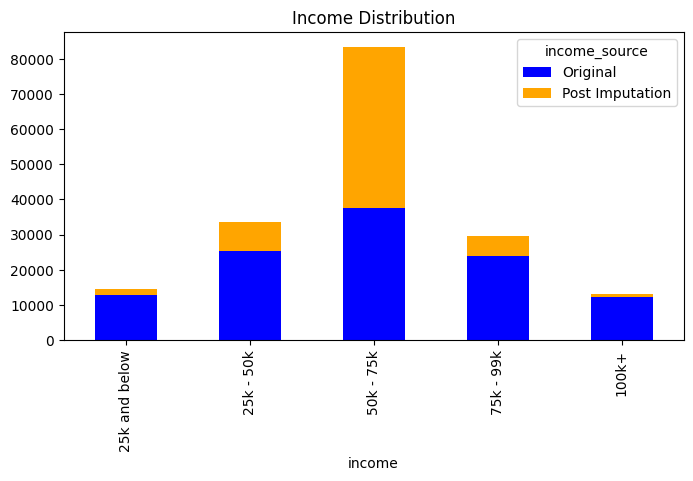

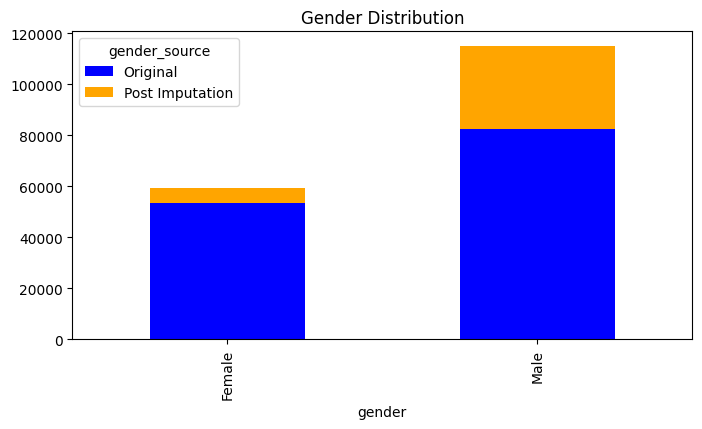

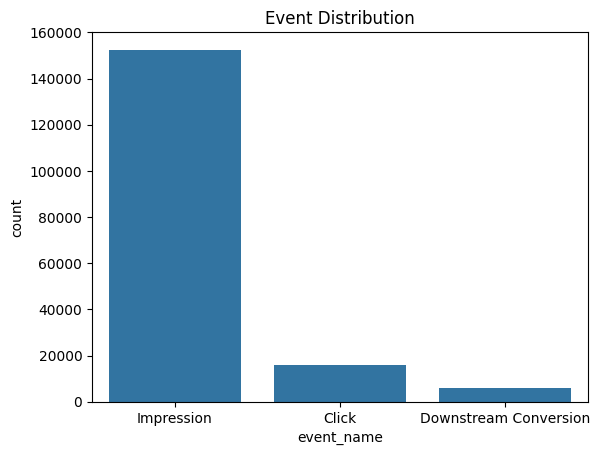

In [925]:
# Histogram for 'income'
df_income.plot(kind='bar', stacked=True, color=['blue', 'orange'], figsize=(8, 4),)
plt.title('Income Distribution')
plt.show()

# Bar chart for 'gender'
df_gender.plot(kind='bar', stacked=True, color=['blue', 'orange'], figsize=(8, 4),)
plt.title('Gender Distribution')
plt.show()

# Bar chart for 'gender'
sns.countplot(x='event_name', data=df_events)
plt.title('Event Distribution')
plt.show()

This plots allows us to understand the distribution for gender, income and event type:
- The income follow a normal distribution, but there are many unknown values that complicate our interpretation of the data, we can see that the group with higher users is the $50K-$75K, presenting the economic situation of the people envolved in this dataset
- The number of male is almost the double of female, but also, a considerable number of unknown values disturbing our analysis
- As expected, it need a lot of impressions to get a click and even less impressions will lead to a downstream conversion

Now let's analyze the events by the gender:

In [926]:
df_events.income.drop_duplicates()

0          25k - 50k
6          50k - 75k
30         75k - 99k
228            100k+
282    25k and below
Name: income, dtype: category
Categories (5, object): ['25k and below' < '25k - 50k' < '50k - 75k' < '75k - 99k' < '100k+']

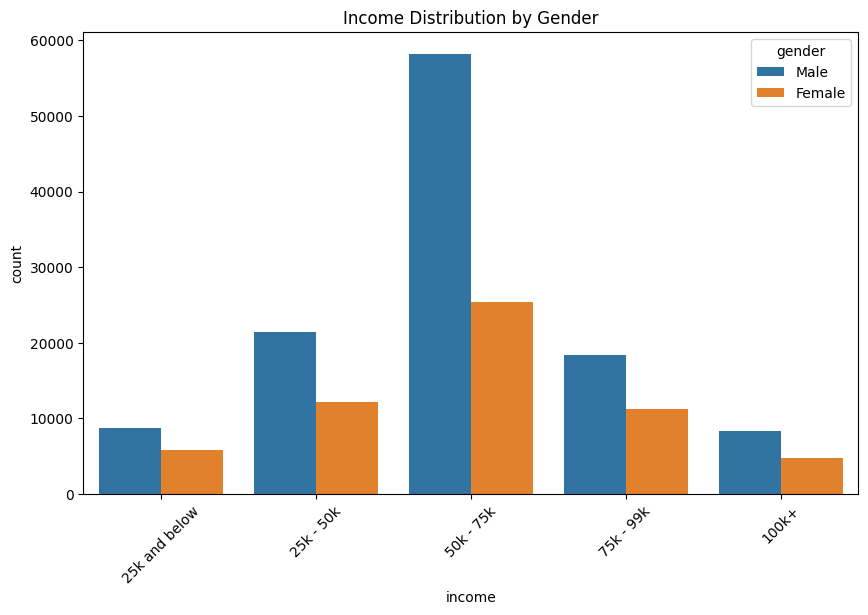

In [927]:
# Grouped bar chart for 'campaign_name' by 'region' and 'gender'
plt.figure(figsize=(10, 6))
sns.countplot(x='income',hue='gender', data=df_events, order=['25k and below','25k - 50k','50k - 75k','75k - 99k','100k+'])
plt.title('Income Distribution by Gender')
plt.xticks(rotation=45)
plt.show()

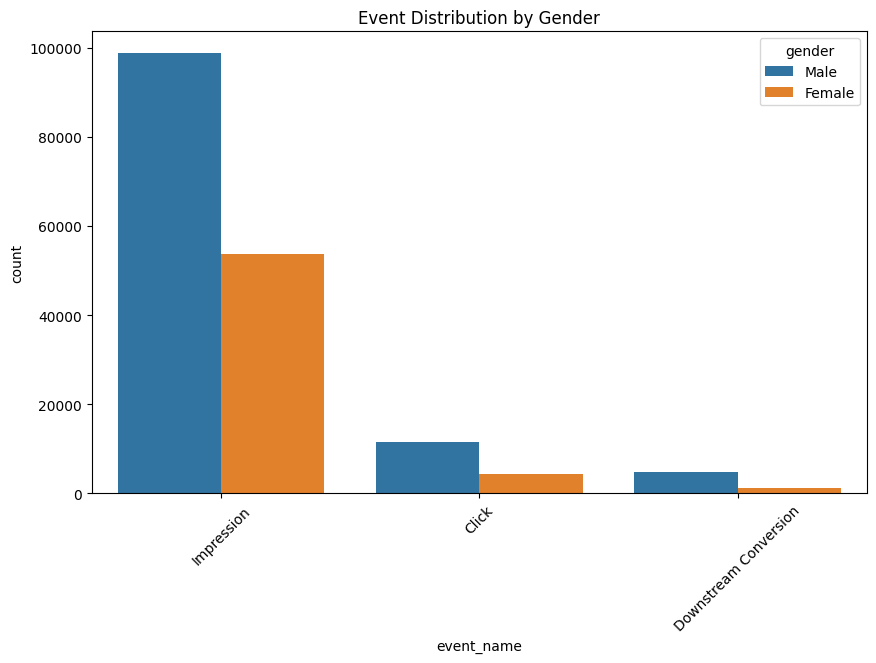

In [928]:
# Grouped bar chart for 'campaign_name' by 'region' and 'gender'
plt.figure(figsize=(10, 6))
sns.countplot(x='event_name',hue='gender', data=df_events)
plt.title('Event Distribution by Gender')
plt.xticks(rotation=45)
plt.show()

- The largest group for males and females is in the $50K-$75K income range
- There's a noticeable disparity in income distribution between genders. Males are more represented in higher income brackets
- Notably, males have the highest count of impressions
- So, we can see that the greater male presence affects all categories

Let's analyze the countries:

In [929]:
#Getting the complete country name from the acronym
def get_country_name(alpha_2):
    try:
        return pycountry.countries.get(alpha_2=alpha_2).name
    except:
        return None
    
df_events['country_name'] = df_events['country'].apply(get_country_name)


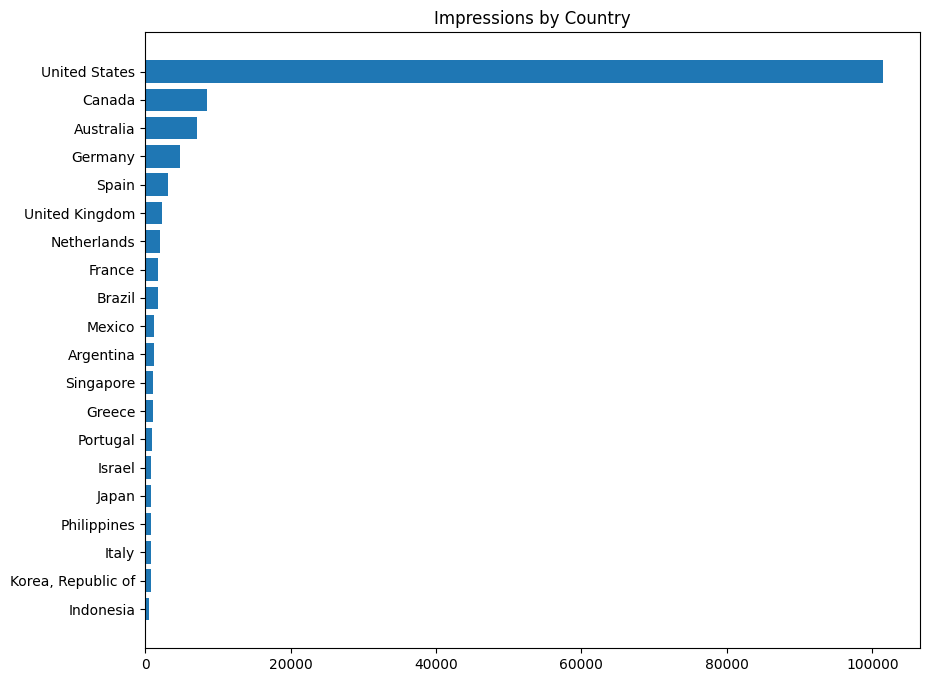

In [930]:
#Aggregating the events by country
df_country = pd.pivot_table(data=df_events, index=['country_name'], columns=['event_name'], aggfunc='size')
df_country.fillna(0, inplace=True)
df_country.reset_index(inplace=True)
df_country.sort_values('Impression', inplace=True)

#Barplot of impressions by country
plt.figure(figsize=(10,8))
plt.barh(df_country.tail(20)['country_name'], df_country.tail(20)['Impression'])
plt.title('Impressions by Country')
plt.show()


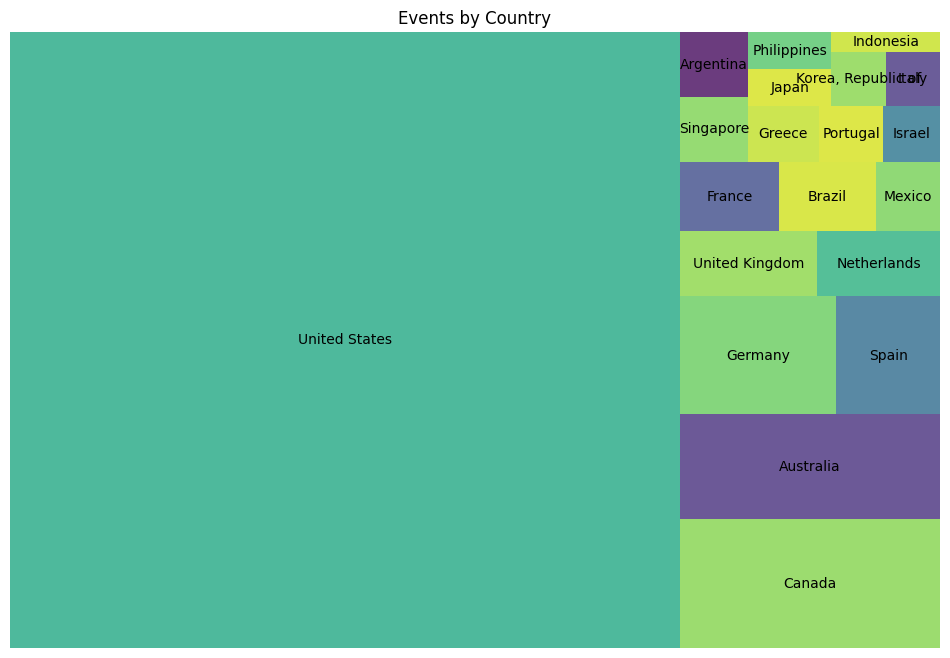

In [931]:
#Getting the count of events by country
country_counts = df_events['country_name'].value_counts().head(20)

#Tree map plot
plt.figure(figsize=(12, 8))
squarify.plot(sizes=country_counts, label=country_counts.index, alpha=0.8)
plt.axis('off')
plt.title('Events by Country')
plt.show()

So, it is visible that US presents a major concentration of the impressions and events, all of the 19 countries in the top 20 combined doesn't present a half of the US events. This probably is related to the source of this data. 
Once that USA present the largest concentration, we are going to divide USA based on it's regions to have a better understading of each region concentration.

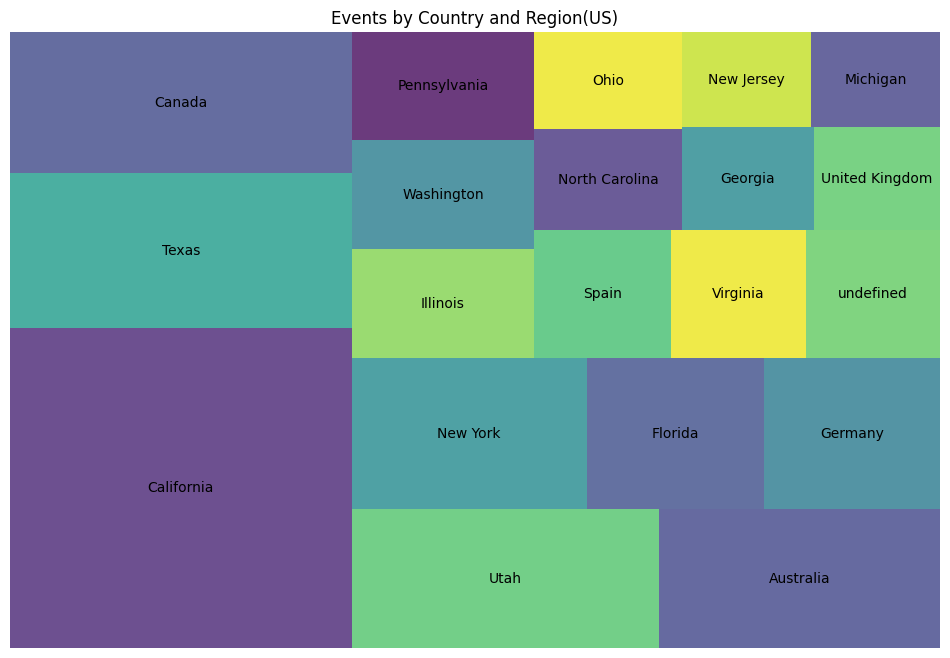

In [932]:
df_events['country_region'] = np.where(df_events['country'] == 'US', df_events['region'], df_events['country_name'])
country_reg_counts = df_events['country_region'].value_counts().head(20)
plt.figure(figsize=(12, 8))
squarify.plot(sizes=country_reg_counts, label=country_reg_counts.index, alpha=0.8)
plt.axis('off')
plt.title('Events by Country and Region(US)')
plt.show()

In [933]:
df_user_events = pd.pivot_table(data=df_events, index=['user_id'], columns=['event_name'], aggfunc='size').fillna(0)
df_user_events.sort_values('Impression', ascending=False).head(5)

event_name,Click,Downstream Conversion,Impression
user_id,,,
2147483647,739.0,279.0,9768.0
637519150,0.0,0.0,26.0
637050303,0.0,0.0,23.0
637236977,0.0,0.0,20.0
637573110,2.0,0.0,20.0


In [934]:
df_user_events.sort_values('Click', ascending=False).head(5)

event_name,Click,Downstream Conversion,Impression
user_id,,,
2147483647,739.0,279.0,9768.0
636886925,5.0,1.0,9.0
637538280,4.0,2.0,10.0
637254491,4.0,2.0,5.0
637122805,4.0,1.0,8.0


Here, it's possible also to track the users that engaged most with the events

Let's now analyze the campaigns:

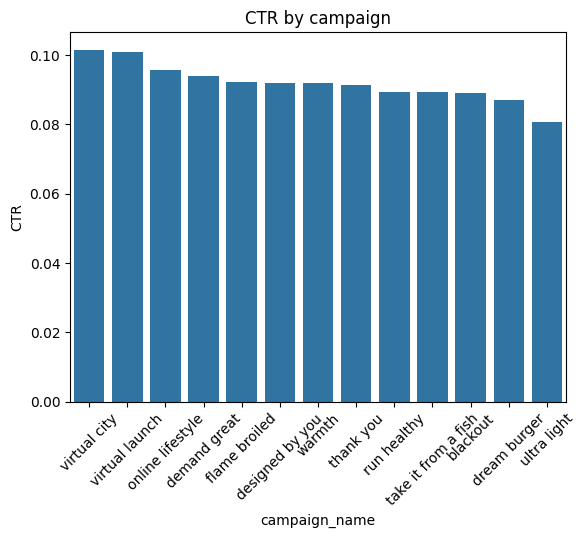

In [935]:
df_campaign_ctr = pd.pivot_table(data=df_events, index=['campaign_name'], columns=['event_name'], aggfunc='size').reset_index().rename_axis(None, axis=1)
df_campaign_ctr['ctr'] = df_campaign_ctr['Click']/(df_campaign_ctr['Click']+df_campaign_ctr['Downstream Conversion']+df_campaign_ctr['Impression'])
sns.barplot(data=df_campaign_ctr.sort_values('ctr', ascending=False), x='campaign_name', y='ctr')
plt.xticks(rotation = 45)
plt.title('CTR by campaign')
plt.ylabel('CTR')
plt.show()


Boxplot

In [936]:
df_campaign_performance = df_events.groupby('campaign_name').nunique().reset_index()
df_campaign_performance = df_campaign_performance.sort_values('user_id', ascending=False)[['campaign_name','user_id', 'region', 'page_url', 'country', 'advertiser']]

In [937]:
df_campaign_performance = df_campaign_performance.merge(df_campaign_ctr, on='campaign_name') 

The top 3 campaigns based on CTR are virtual launch, virtual city and online lifestyle, it is also notable the campaigns that most were showed to differnet users, countries and the ones with most advertisers: dream burguer, flame broiled and thank you. The low performance of campaigns like dream burguer in CTR can be explained by the fact that is a campaign showed to many people but the target audience it was not well chosen

In [938]:
df_campaign_gender = pd.pivot_table(df_events, values='user_id', index='campaign_name', columns='gender', aggfunc='count', fill_value=0).reset_index().rename_axis(None, axis=1)
df_campaign_gender

,campaign_name,Female,Male
0,blackout,1917,3315
1,demand great,3305,6056
2,designed by you,3311,5776
3,dream burger,14035,29528
4,flame broiled,10715,21578
5,online lifestyle,2371,3849
6,run healthy,4684,9204
7,take it from a fish,2742,4868
8,thank you,7345,14483
9,ultra light,479,710


hot-encoding: leave one out
pandas: get dummies

In [939]:
df_campaign_performance = df_campaign_performance.merge(df_campaign_gender, on='campaign_name')
df_campaign_performance

,campaign_name,user_id,region,page_url,country,advertiser,Click,Downstream Conversion,Impression,ctr,Female,Male
0,dream burger,22881,100,2198,81,97,3792,1389,38382,0.087046,14035,29528
1,flame broiled,18522,100,1930,80,97,2980,1137,28176,0.092280,10715,21578
2,thank you,13238,100,1659,73,97,1991,734,19103,0.091213,7345,14483
3,warmth,11816,100,1552,74,96,1782,700,16938,0.091761,6556,12864
4,run healthy,8697,100,1313,69,94,1241,477,12170,0.089358,4684,9204
5,demand great,5988,100,1099,66,93,880,320,8161,0.094007,3305,6056
6,designed by you,5788,100,1068,64,95,836,310,7941,0.092000,3311,5776
7,take it from a fish,4897,100,1003,60,95,680,267,6663,0.089356,2742,4868
8,online lifestyle,4071,100,954,59,92,595,218,5407,0.095659,2371,3849
9,blackout,3483,100,850,57,89,465,179,4588,0.088876,1917,3315


Treat unknown values v

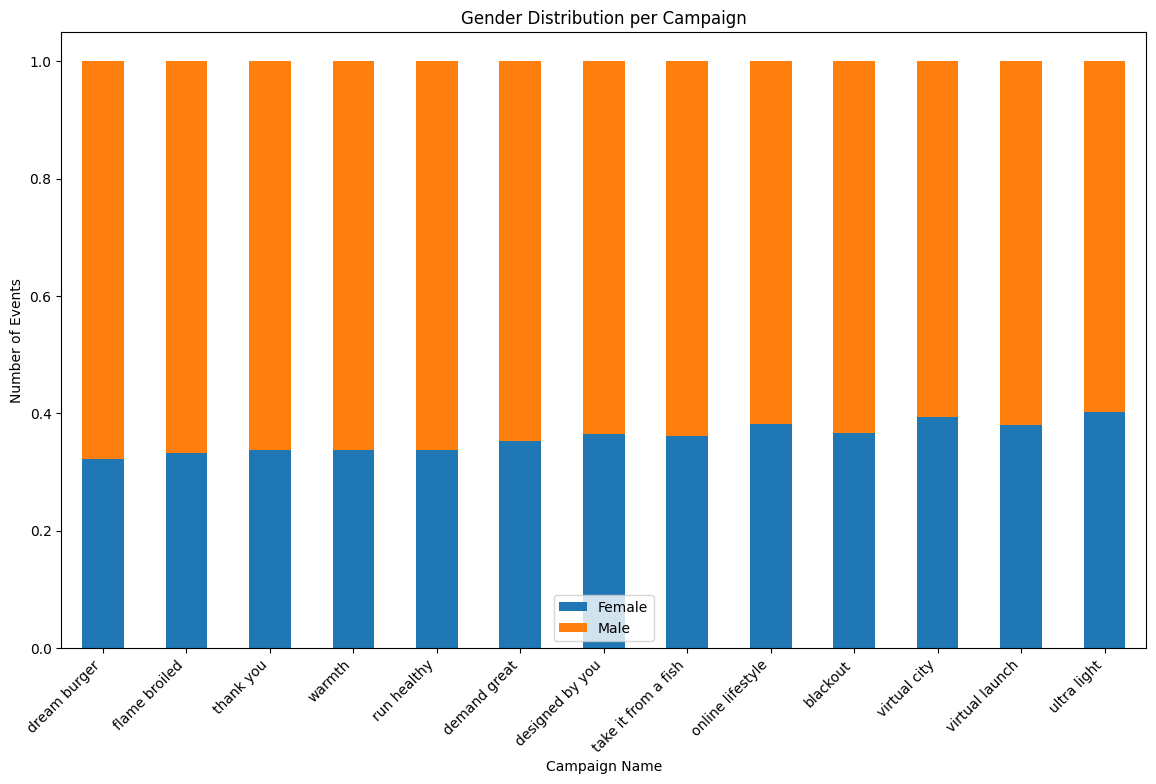

In [940]:
total_events_per_campaign = df_campaign_performance[['Female', 'Male']].sum(axis=1)
normalized_data = df_campaign_performance[['Female', 'Male']].div(total_events_per_campaign, axis=0)
normalized_data.set_index(df_campaign_performance['campaign_name']).plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Gender Distribution per Campaign')
plt.ylabel('Number of Events')
plt.xlabel('Campaign Name')
plt.xticks(rotation=45, ha="right")
plt.show()

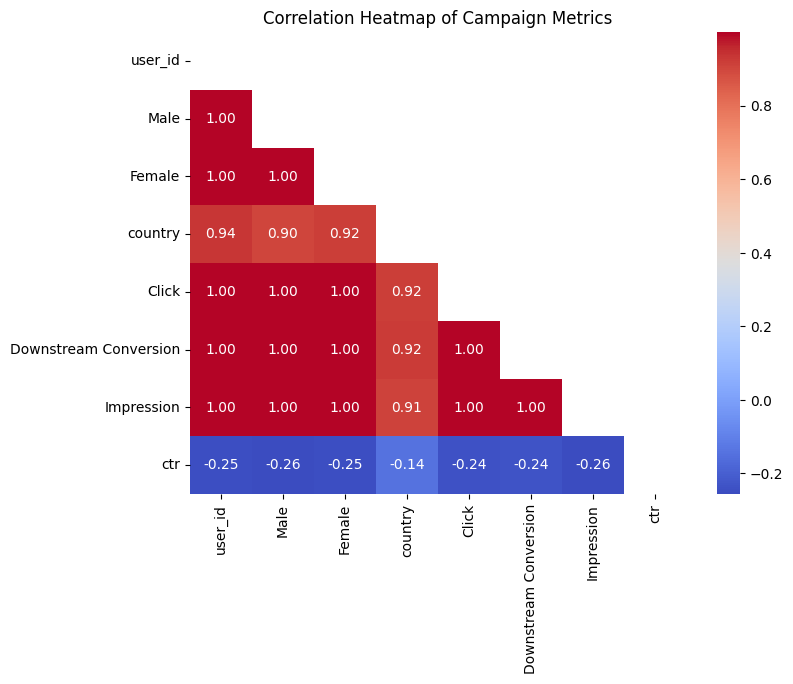

In [941]:
# Calculating correlations
correlations =  df_campaign_performance[['user_id', 'Male', 'Female','country','Click', 'Downstream Conversion', 'Impression', 'ctr']].corr()

mask = np.triu(np.ones_like(correlations, dtype=bool))

# Plotting heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.title('Correlation Heatmap of Campaign Metrics')
plt.show()

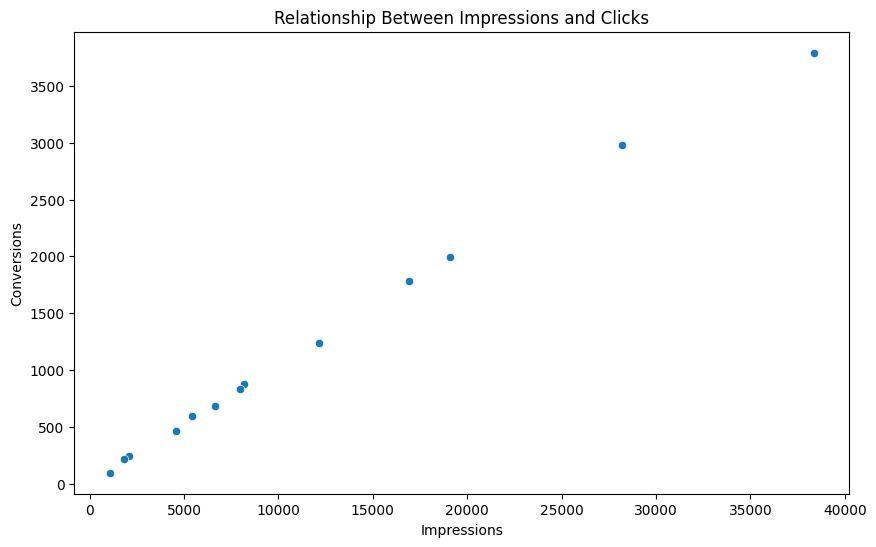

In [942]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Impression', y='Click', data=df_campaign_performance)
plt.title('Relationship Between Impressions and Clicks')
plt.xlabel('Impressions')
plt.ylabel('Conversions')
plt.show()

In order to understand how the CTR is related to the data features, let's plot the CTR(based on gender, income and country) boxplot by gender and income:

/var/folders/fc/68g79hcs3fv874cy848tfm_w0000gn/T/ipykernel_45601/2877956990.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  clicks = df_events[df_events['event_name'] == 'Click'].groupby(['gender', 'income', 'country']).size()
/var/folders/fc/68g79hcs3fv874cy848tfm_w0000gn/T/ipykernel_45601/2877956990.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  impressions = df_events[df_events['event_name'] == 'Impression'].groupby(['gender', 'income', 'country']).size()


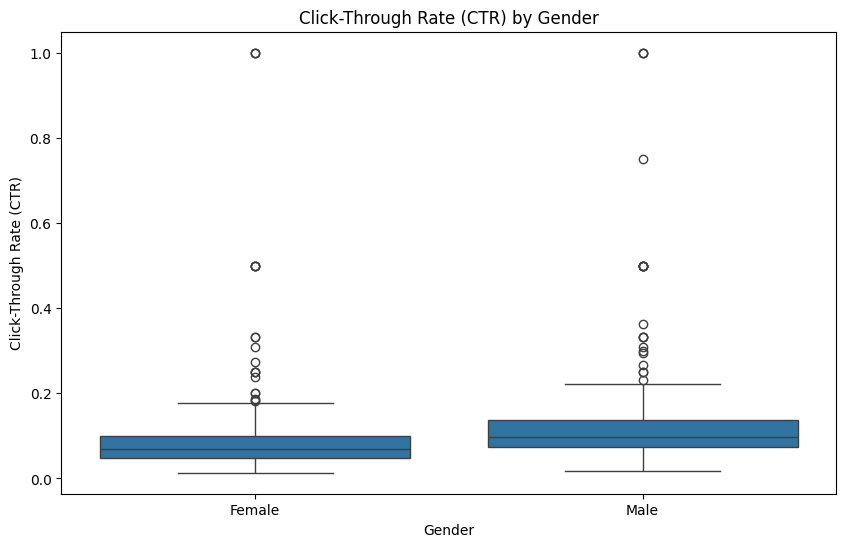

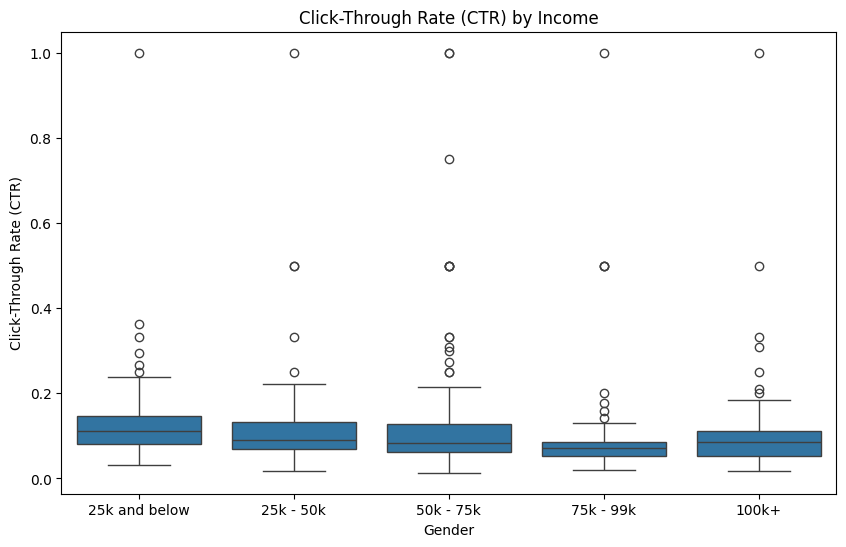

In [952]:
clicks = df_events[df_events['event_name'] == 'Click'].groupby(['gender', 'income', 'country']).size()
impressions = df_events[df_events['event_name'] == 'Impression'].groupby(['gender', 'income', 'country']).size()
ctr = (clicks / impressions).fillna(0).reset_index(name='CTR')

# Plot box plots
plt.figure(figsize=(10, 6))
sns.boxplot(data=ctr[ctr['CTR'] !=0], x='gender', y='CTR')
plt.title('Click-Through Rate (CTR) by Gender')
plt.xlabel('Gender')
plt.ylabel('Click-Through Rate (CTR)')
plt.show()


# Plot box plots
plt.figure(figsize=(10, 6))
sns.boxplot(data=ctr[ctr['CTR'] !=0], x='income', y='CTR')
plt.title('Click-Through Rate (CTR) by Income')
plt.xlabel('Gender')
plt.ylabel('Click-Through Rate (CTR)')
plt.show()

drop the ctr-0 cases, groups are not suficients

Now, let's analyze the features importance, to do so, we are goin to apply two methods the chi-squared test and the mutual information score. To conduct the tests we are going to assume that the target is a new feature called "is_click", a boolean that shows if that event lead to a click or not.

In [944]:
df_events['is_click'] = np.where(df_events['event_name']=="Click",1,0) #Creating the is_click feature

In [945]:
df_events_sample = df_events.sample(n=10000, random_state=42) #Sample the data because chi-score test is sensitive to the sample size

#Get the contigency tables for each feature
crosstab_gender = pd.crosstab(df_events_sample['gender'], df_events_sample['is_click'])
crosstab_income = pd.crosstab(df_events_sample['income'], df_events_sample['is_click'])
crosstab_region= pd.crosstab(df_events_sample['region'], df_events_sample['is_click'])
crosstab_advertiser= pd.crosstab(df_events_sample['advertiser'], df_events_sample['is_click'])


#Calculate p value, dof, and expected values for each feature
prob = 0.95
p_values = {}
chi2_gender, p_values['gender'], dof_gender, expected_gender = chi2_contingency(crosstab_gender)
critical_gender = chi2.ppf(prob,dof_gender)
chi2_income, p_values['income'], dof_income, expected_income = chi2_contingency(crosstab_income)
critical_income = chi2.ppf(prob,dof_income)
chi2_region, p_values['region'], dof_region, expected_region = chi2_contingency(crosstab_region)
critical_region = chi2.ppf(prob,dof_region)
chi2_advertiser, p_values['advertiser'], dof_advertiser, expected_advertiser = chi2_contingency(crosstab_advertiser)
critical_region = chi2.ppf(prob,dof_region)

In [946]:
#Relationship between features and target analysis
alpha = 0.05
for variable, p_value in p_values.items():
    if p_value < alpha:
        print(f"The relationship between {variable} and click is statistically significant.")
    else:
        print(f"No significant relationship between {variable} and click.")

The relationship between gender and click is statistically significant.
The relationship between income and click is statistically significant.
No significant relationship between region and click.
The relationship between advertiser and click is statistically significant.


We can see, that based on a 10000 samples data, only the region doesn't present a statistically significant relationship with the target

Stratification for sampling - Studie

In [947]:
for variable, p_value in p_values.items():
    print(f"{variable} p-value:{p_value.round(4)}")

gender p-value:0.0
income p-value:0.0417
region p-value:0.2778
advertiser p-value:0.0054


Let's perform a MI score analysis also, based on the is_click feature as target:

- Remove zeros
- Plot imputation vs original


In [948]:
X = df_events.drop(columns=['event_name', 'is_click'])
y = df_events['is_click']

In [953]:
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()
discrete_features = X.dtypes == int

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)

ValueError: could not convert string to float: '25k - 50k'

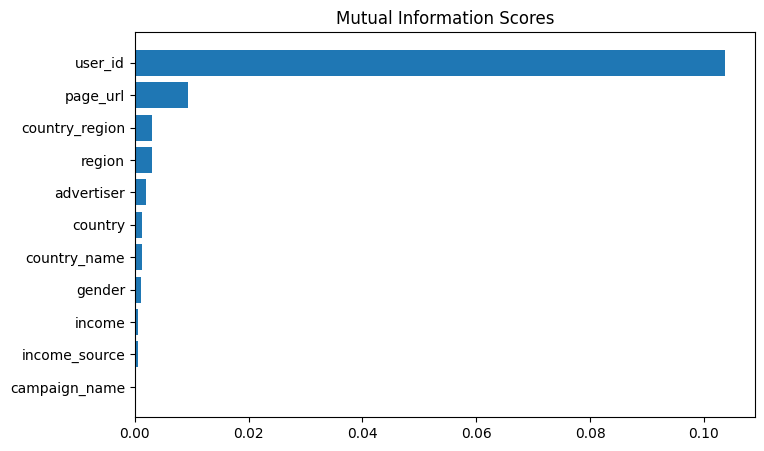

In [ ]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

The tests presented different results, once that by chi-square test, the region doesn't present a significant relationship with the target but based on the MI score is one of the features with higher score. 
This is related to the different output of each test, and its formulation, a good practice may be the empirical test for models running with the best features for each test and compare their performance.